In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import cv2
import numpy as np
import random

In [3]:
clicked_points = []

#mouse callback
def mouse_callback(event, x, y, flags, param):
    global clicked_points
    if event == cv2.EVENT_LBUTTONDOWN:
        clicked_points.append((x, y))
        print("Clicked at (x={}, y={})".format(x, y))
        cv2.circle(image, (x, y), 3, (0, 0, 255), -1) 
        cv2.imshow('image', image)

#load image
image = cv2.imread('1311 Central Tank Reserve Base.jpg')
cv2.imshow('image', image)
cv2.setMouseCallback('image', mouse_callback)

#quit
while True:
    key = cv2.waitKey(1) & 0xFF
    if key == ord('q'):
        break

#write to file
with open('clicked_coordinates.txt', 'w') as f:
    for point in clicked_points:
        f.write('{} {}\n'.format(point[0], point[1]))

cv2.destroyAllWindows()

In [2]:
#which images to pick

random_array = np.random.randint(0, 3, size=10000)

#load images and annotations
image_paths = ["22 Central Tank Reserve Base.jpg", "111 Central Tank Reserve Base.jpg", "1295 Central Tank Reserve Base.jpg"] 
annotations_files = ["22CTRBAnnotation.txt", "111CTRBAnnotation.txt", "1295CTRBAnnotation.txt"] 

#load images
images = [cv2.imread(image_paths[0]), cv2.imread(image_paths[1]), cv2.imread(image_paths[2])]
imageloc = []

num_patches = 10000

def extract_patches(num_patches, seed):
    patches = []
    image_height, image_width = images[0].shape[:2]
    patch_size = 256

    for i in range(num_patches):
        #get random coordinates
        x = np.random.randint(0, image_width - patch_size)
        y = np.random.randint(0, image_height - patch_size)
        patch = images[seed[i]][y:y+patch_size, x:x+patch_size]
        imageloc.append((x,y))
        patches.append(patch)

    return patches

def load_annotations(annotations_file):
    annotations = np.loadtxt(annotations_file, dtype=int)
    return annotations

patches = extract_patches(num_patches, random_array)
annotations = [load_annotations(annotations_files[0]), load_annotations(annotations_files[1]), load_annotations(annotations_files[2])]

#prep training data
x_train = np.array(patches)
y_train = []

#assign numbers to the patches
for i in range(len(patches)):
    patch_count = 0
    annotation = annotations[random_array[i]]
    for j in range(len(annotation)):
        x, y = annotations[random_array[i]][j]
        if x >= imageloc[i][0] and x < imageloc[i][0]+256 and y >= imageloc[i][1] and y < imageloc[i][1] + 256:
            patch_count += 1
    y_train.append(patch_count)

y_train = np.array(y_train)

In [3]:
#build tensorflow model
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),

    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dense(128, activation='relu'),

    layers.Dense(64, activation='relu'),
    layers.Dense(1)
])

#compile
model.compile(optimizer='adam',
              loss='mean_squared_error',#regression loss function
              metrics=['mae'])#mean absolute error as a metric

#train
model.fit(x_train, y_train, epochs=100, validation_split=0.2)

model.save("model.h5")

Train on 8000 samples, validate on 2000 samples
Epoch 1/100
8000/8000 [==============================] - 404s 50ms/sample - loss: 3419.1581 - mae: 39.7079 - val_loss: 1006.5545 - val_mae: 22.2600
Epoch 2/100
8000/8000 [==============================] - 420s 52ms/sample - loss: 678.2664 - mae: 18.1016 - val_loss: 412.8216 - val_mae: 15.0560
Epoch 3/100
8000/8000 [==============================] - 436s 54ms/sample - loss: 338.3129 - mae: 12.6141 - val_loss: 351.5606 - val_mae: 13.0554
Epoch 4/100
8000/8000 [==============================] - 430s 54ms/sample - loss: 182.1516 - mae: 9.1676 - val_loss: 181.3004 - val_mae: 9.2247
Epoch 5/100
8000/8000 [==============================] - 418s 52ms/sample - loss: 157.8541 - mae: 8.2313 - val_loss: 272.8938 - val_mae: 11.4853
Epoch 6/100
8000/8000 [==============================] - 402s 50ms/sample - loss: 101.0212 - mae: 6.6527 - val_loss: 105.0569 - val_mae: 7.1703
Epoch 7/100
8000/8000 [==============================] - 415s 52ms/sample - los

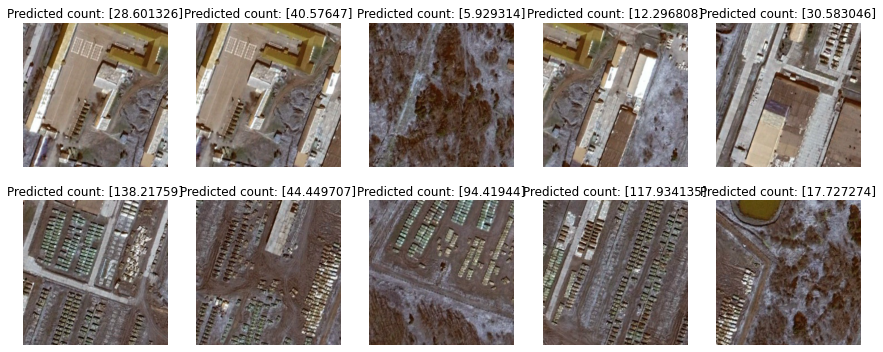

In [16]:

#generate 10 test patches
test_image = cv2.imread("2544 Central Tank Reserve Base.jpg")
test_patches = []
image_height, image_width = images[0].shape[:2]
patch_size = 256

for i in range(10):
    x = np.random.randint(0, image_width - patch_size)
    y = np.random.randint(0, image_height - patch_size)
    patch = test_image[y:y+patch_size, x:x+patch_size]
    imageloc.append((x,y))
    test_patches.append(patch)

test_patches = np.array(test_patches)

#run em through the model
predictions = model.predict(test_patches)
#display em
fig, axs = plt.subplots(2, 5, figsize=(15, 6))

for i, (image, prediction) in enumerate(zip(test_patches, predictions)):
    ax = axs[i // 5, i % 5]
    ax.imshow(image)
    ax.axis('off')
    ax.set_title(f'Predicted count: {prediction}')

plt.show()